# Iterative Prisoner's Dilemma


### Description

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

In an Iterative Prisoner's Dilemma (IPD), two players play prisoner's dilemma more than once in succession and they remember previous actions of their opponent and change their strategy accordingly. The winning strategy is the one which yields to a larger reward at the end of the IPD.

The strategy can be represented as a function which outputs either $u_C$ or $u_D$. Such function can depend on the opponent's history of moves, her on history of moves, on the number of moves played till that moment and so on, but it can only be based on a probability density function. Possible strategies are:

* **Nice guy**: always cooperate (the function's output is always $u_D$)
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k<50$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $100-k\%$, $k>50$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

Many more and much more complex strategies can be implemented. The strategy can even change during the IPD.


### Assignments

* Implement a simple IPD between two players implementing two given strategies. Study the evolution along the tournament confronting different strategies; study the overall outcome in the different configurations. 
* Implement a multiple players IPD (MPIPD) where several strategies play against each other in a roud-robin scheme
* Iterate what done in the previous task (repeated MPIPD, rMPIPD)  by increasing the population implementing a given strategy depending on the results that strategy achieved in the previous iteration
* (*difficult*) Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natura selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from IPython.display import display
import it_pris_dil_func as pris_dil
import graph_func as grf

In [2]:
#Point 1)

s = ['nice','bad','m_nice','m_bad','tit_tat',
    'random','grim','f_tit_tat','sus_tit_tat',
    'pavlov','reactive_nice','reactive_bad',
    'hard_joss','soft_joss']

#s = ['nice','bad','m_nice','m_bad','tit_tat']

result = np.zeros((len(s),len(s)))
for i in range(len(s)):
    for j in range(i,len(s)):
        p1, p2 = pris_dil.fight(s[i],s[j],face = True)
        result[i,j] = p1
        result[j,i] = p2

df = pd.DataFrame(result,dtype=int,columns=s,index=s)

#Rappresentazione risultati
def colorcell(x):
    data = x.copy()
    data.loc[:,:] = ''
    for i in range(len(s)):
        for j in range(len(s)):
            if result[i,j] < result[j,i]: data.iloc[i,j] = 'color : red'
            elif result[i,j] > result[j,i]: data.iloc[i,j] = 'color : green'
            else: data.iloc[i,j] = 'color : gray'
    return data

sum = np.sum(result, axis=1)
df['result'] = sum
df = df.astype({'result': int})
df = df.style.apply(colorcell,axis=None)

display(df)


,nice,bad,m_nice,m_bad,tit_tat,random,grim,f_tit_tat,sus_tit_tat,pavlov,reactive_nice,reactive_bad,hard_joss,soft_joss,result
nice,300,0,231,81,300,156,300,300,297,300,213,87,261,300,3126
bad,500,100,360,180,104,292,104,108,100,300,192,388,104,152,2984
m_nice,346,35,238,157,267,198,45,322,254,222,232,141,236,272,2965
m_bad,446,80,302,184,194,250,73,267,182,246,260,307,177,213,3181
tit_tat,300,99,267,189,300,243,300,300,250,300,223,220,115,300,3406
random,396,52,288,135,243,188,57,308,237,212,216,213,210,258,3013
grim,300,99,385,223,300,307,300,300,103,300,231,347,163,300,3658
f_tit_tat,300,98,237,147,300,183,300,300,297,300,216,181,259,300,3418
sus_tit_tat,302,100,254,187,250,242,103,302,100,203,227,220,112,300,2902
pavlov,300,50,277,166,300,247,300,300,198,300,232,224,200,300,3394


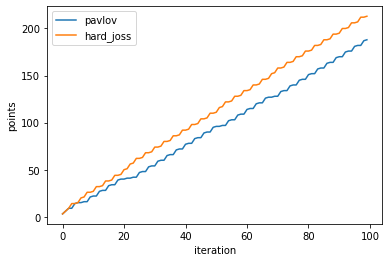

In [28]:
s = ['nice','bad','m_nice','m_bad','tit_tat',
    'random','grim','f_tit_tat','sus_tit_tat',
    'pavlov','reactive_nice','reactive_bad',
    'hard_joss','soft_joss']

res1, res2, p1, p2 = pris_dil.fight('random','grim',graph=True,all_outcome=True)

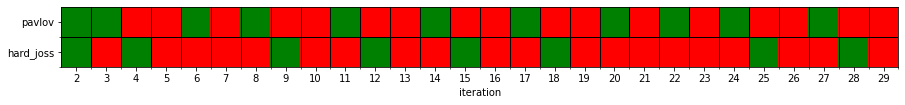

In [31]:
grf.fight_grid(p1,p2,range=[2,30])

nice 2
bad 2
m_nice 3
m_bad 4
grim 3
f_tit_tat 1
sus_tit_tat 2
pavlov 3
reactive_nice 3
reactive_bad 2
hard_joss 2
soft_joss 3


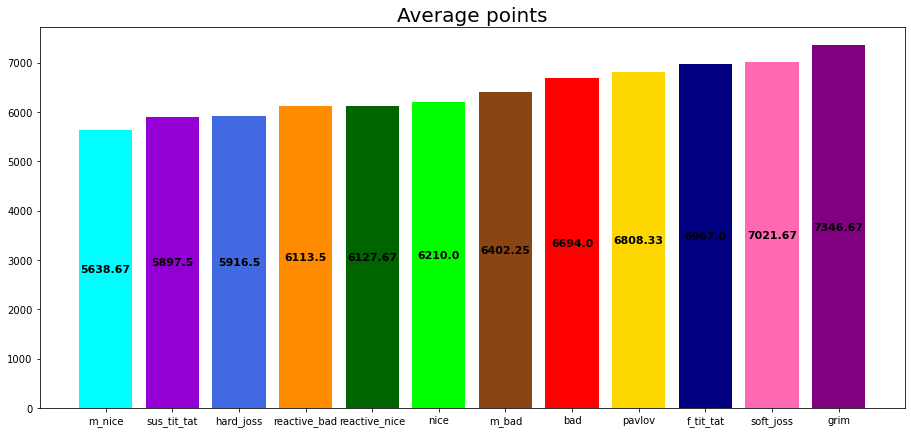

In [32]:
#Point 2)
'''
s = ['nice','bad','m_nice','m_bad','tit_tat',
    'random','grim','f_tit_tat','sus_tit_tat',
    'pavlov','reactive_nice','reactive_bad',
    'hard_joss','soft_joss']'''

s = ['nice','m_nice','reactive_nice','soft_joss',
    'bad','m_bad','reactive_bad','hard_joss',
    'tit_tat','f_tit_tat','sus_tit_tat','grim']
s_good = ['nice','m_nice','reactive_nice','soft_joss']
s_bad = ['bad','m_bad','reactive_bad','hard_joss']
s_tit_tat = ['tit_tat','f_tit_tat','sus_tit_tat']

h = []
for i in range(17):
    h.append(npr.randint(4))
for i in range(17):
    h.append(npr.randint(4,8))
for i in range(16): h.append(npr.randint(8,11))
h.append(11)
#h = npr.randint(0,len(s),size=50)
unique, n_strategies = np.unique(h,return_counts=True)

for a,b in zip(unique,n_strategies): print(s[a],b)

unique, media, n_strat = pris_dil.round_robin(h,s,ord=True)

s_unique = [s[val] for val in unique]

grf.graph_bar(media,unique,n_strat,s)


In [73]:
#Point 3)

s = ['nice','bad','m_nice','m_bad','tit_tat',
    'random','grim','f_tit_tat','sus_tit_tat',
    'pavlov','reactive_nice','reactive_bad',
    'hard_joss','soft_joss']

#s = ['nice','bad','m_nice','m_bad','tit_tat']
'''s = ['nice','reactive_nice','soft_joss',
    'bad','reactive_bad','hard_joss',
    'tit_tat','f_tit_tat','sus_tit_tat']'''
#h = npr.randint(0,len(s),size=100)

s = ['bad','m_bad','tit_tat']

h = pris_dil.h_build([45,46,9])
  
unique, n_strategies = np.unique(h,return_counts=True)

for a,b in zip(unique,n_strategies): print(s[a],b)

bad 45
m_bad 46
tit_tat 9


In [74]:
iterations = 100
n_ma3, val_ma3, break_it = pris_dil.tournament(h,'update_5',s,it=iterations,n_change=2)

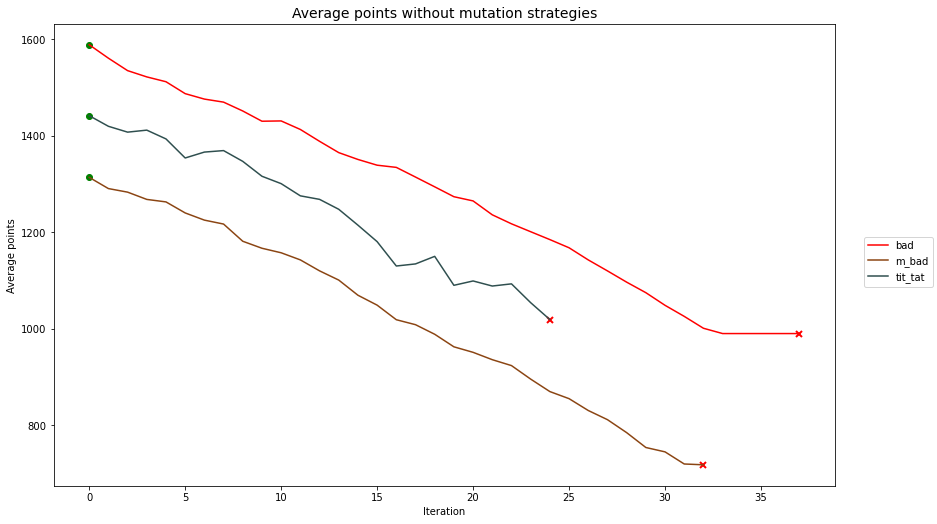

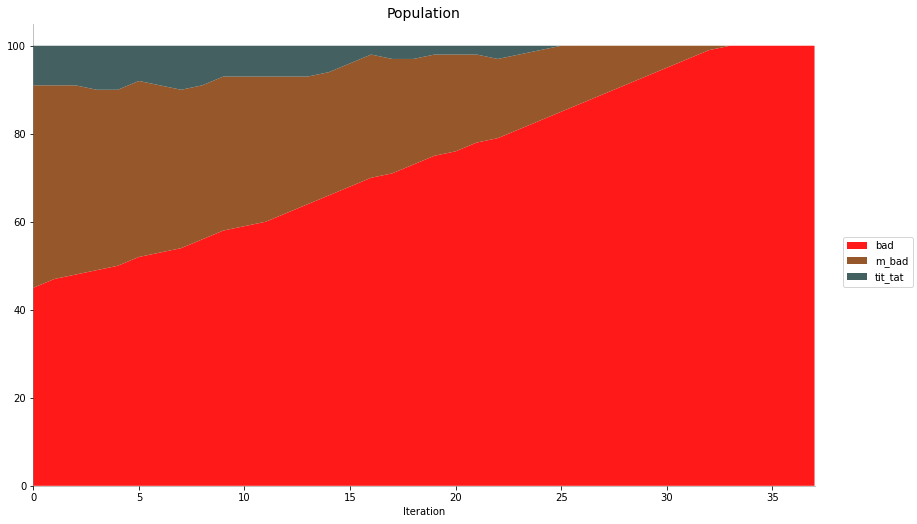

In [75]:
grf.graph_avarege(h,val_ma3,s,break_it)
grf.graph_population(n_ma3,break_it,s)

In [2]:
grf.gif(s,n_ma3,'population_3',s_colors)

nice 5
bad 5
m_nice 5
m_bad 5
tit_tat 5
random 5
grim 5
f_tit_tat 5
sus_tit_tat 5
pavlov 5
reactive_nice 5
reactive_bad 5
hard_joss 5
soft_joss 5


In [ ]:
#Point 4)

s = ['nice','bad','m_nice','m_bad','tit_tat',
    'random','grim','f_tit_tat','sus_tit_tat',
    'pavlov','reactive_nice','reactive_bad',
    'hard_joss','soft_joss']
    
start_s = len(s)
#n_players = 14
#h = np.zeros((2,np.sum(numbers)))
#h[0] = npr.randint(0,len(s),size=n_players)
h = pris_dil.h_build(numbers,mutation = True)
#h[1,14] = 0.2
unique, n_strategies = np.unique(h[0],return_counts=True)

for a,b in zip(unique,n_strategies): print(s[int(a)],b)

iterations = 40
n_ma4, val_ma4, iteration = pris_dil.tournament(h,'update_5',s,it=iterations,mutation_prob=0.05, n_change = 3)

24


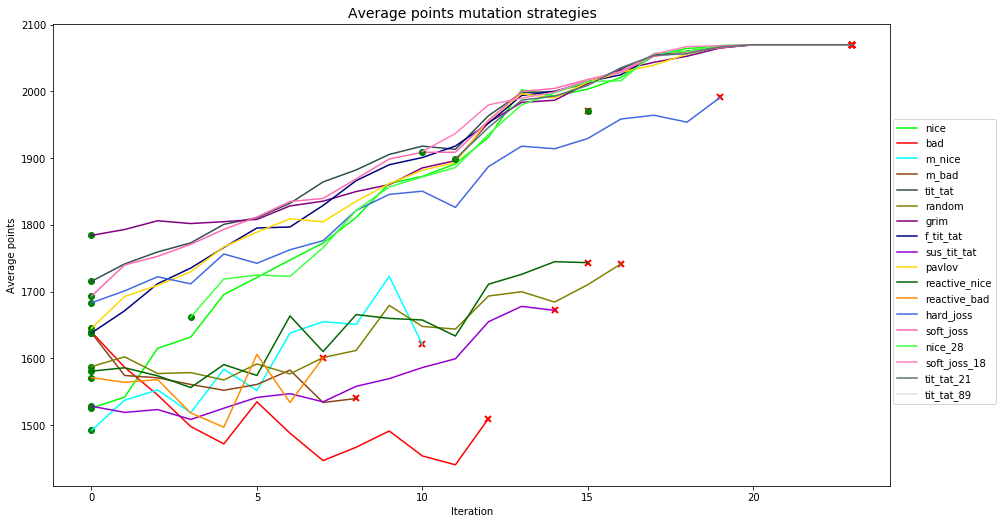

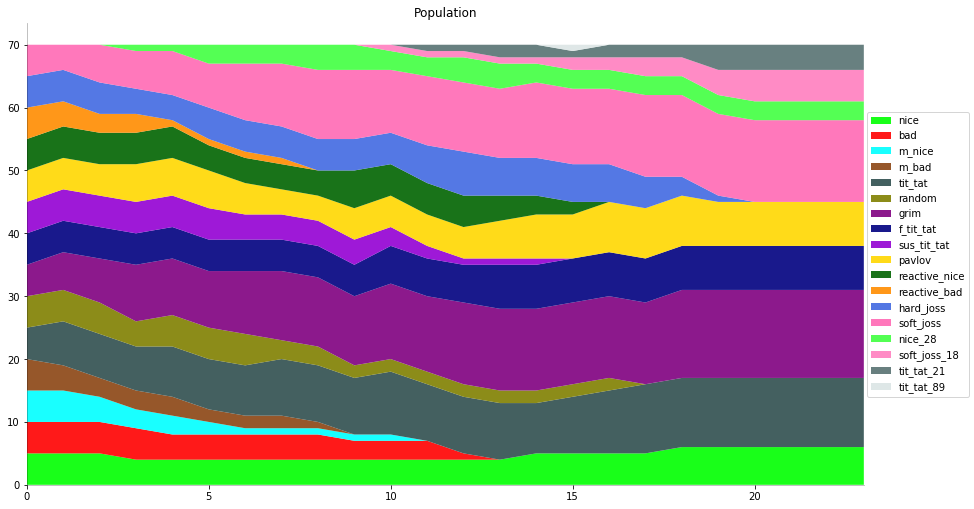

In [3]:
print(iteration)
grf.graph_avarege(h,val_ma4,s,iteration,start_s=start_s)
grf.graph_population(n_ma4,iteration,s,start_s=start_s)

In [17]:
#Gif 4           
grf.gif(s,n_ma4,'population_4',start_s)